# Data loading

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pingouin as pg

In [5]:
# [Load only the one your using into memory, due to large file sizes]

# Read data files 

gaze = pd.read_hdf('annotated_gaze.h5')
# pupillometry = pd.read_hdf('annotated_pupillometry.h5')
blinks = pd.read_csv('annotated_blinks.csv')
fixations = pd.read_hdf('annotated_fixations.h5')
# all_pupil = pd.read_hdf('all_pupillometry.h5')

annots = pd.read_csv('all_annotations.csv')

In [6]:
# Set prefs
sns.set_style("ticks")
colors = sns.color_palette('GnBu',9)

# Monitor variables
w,h = 1920,1200
extent = [0,w,0,h] 

# Defines the areas of interest (AOIs) on monitor for each wordset
borders = {1: {'Other': (0,350), 'Words': (350,780), 'Problem': (780,1200)}, 
           2: {'Other': (0,200), 'Words': (200,750), 'Problem': (750,1200)}} 

# Mapping of participant id to group
def id_to_group(id): return {1:'a', 2:'b', 0:'c'}[id % 3]

# Gaze

## Heatmaps

In [ ]:
def generate_heatmap(x, y, bins=(w,h), blur=0.04,thres=True):
  '''
  blur - this will determine the gaussian blur kernel of the image (higher number = more blur). 
    blur == 0.04 gives Gaussian kernel sd values of respectively 77 and 49 for width and height.

  Based on: https://github.com/pupil-labs/pupil-tutorials/blob/master/02_load_exported_surfaces_and_visualize_aggregate_heatmap.ipynb
  '''
  # 2D histogram
  heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0,w],[0,h]])
  
  # Gaussian blur  
  if blur:
    filter_w = int(blur * w) // 2 * 2 + 1
    filter_h = int(blur * h) // 2 * 2 + 1
  
    heatmap = gaussian_filter(heatmap, sigma=(filter_w, filter_h))

  # Thresholding
  if thres:
    lowbound = np.mean(heatmap[heatmap > 0]) / 2
    heatmap[heatmap < lowbound] = np.nan

  return heatmap

In [ ]:
# Heatmaps per participants over stimuli and wordset and groups

stims = ['Near', 'Far', 'Cntrl']

for wordset in range(1,3):
  for group in range(1,4):
    print(f'Wordset {wordset}, group {id_to_group(group)}')
    fig, axs = plt.subplots(8,3, figsize=(8,15))


    for i in range(8):
      p_id = (3*i) + group 

      # Filter out participant and wordset
      p_gaze = gaze[(gaze.wordset == wordset) & (gaze.participant_id == p_id)]

      for j, stim in enumerate(stims):
        ax = axs[i,j]

        img = np.flipud(plt.imread(f'Wordset images/{id_to_group(j+1)}_problem10_wordset{wordset}.png'))

        data = p_gaze[p_gaze.stimuli == stim]
        N = len(data)
        
        data = data[data.confidence >= 0.8]
        x, y = data[['x_scaled', 'y_scaled']].T.values
        num_ideas = data.groupby('problem_id').first()['idea_total'].sum()

        heatmap = generate_heatmap(x,y)

        ax.imshow(heatmap.T,extent=extent, origin='lower', cmap='RdYlGn_r', alpha=0.85, zorder=1)
        ax.imshow(img, origin='lower', zorder=0)
        ax.text(0.02, 0.02, f'{float(len(data)/N)*100:.1f}%', ha='left', va='bottom', transform=ax.transAxes) 
        ax.text(0.98, 0.02, f'Ideas: {num_ideas}', ha='right', va='bottom', transform=ax.transAxes) 

        if stim == 'Near':
          ax.set_ylabel(f'Participant {p_id}')
        
        if i == 0:
          ax.set_title(stim)
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.5)
    plt.savefig(f'Heatmap_stimuli_wordset{wordset}_{id_to_group(group)}.pdf', dpi=300, bbox_inches='tight')
    # plt.show()

In [ ]:
# Heatmaps per group across stimuli (and wordset)

stims = ['Near', 'Far', 'Cntrl']

# Plot heatmaps

for wordset in range(1,3):
  fig, axs = plt.subplots(3,3, figsize=(6,5.5))

  # Filter on wordset and confidence
  w_data = gaze[(gaze.wordset == wordset) & (gaze.confidence >= 0.8)]
  
  for i in range(3):
    p_ids = [(3*x) + (i+1) for x in range(8)]

    # Filter on participants
    p_data = w_data[w_data.participant_id.isin(p_ids)]

    for j, stim in enumerate(stims):
      ax = axs[i,j]

      img = np.flipud(plt.imread(f'Wordset images/{id_to_group(j+1)}_problem10_wordset{wordset}.png'))

      # Filter on stimuli
      data = p_data[p_data.stimuli == stim]
      x, y = data[['x_scaled', 'y_scaled']].T.values

      heatmap = generate_heatmap(x,y)

      ax.imshow(heatmap.T,extent=extent, origin='lower', cmap='RdYlGn_r', alpha=0.85, zorder=1)
      ax.imshow(img, origin='lower', zorder=0)

      if stim == 'Near':
        ax.set_ylabel(f'Group {id_to_group(i+1).upper()}')
      
      if i == 0:
        ax.set_title(stim)
      
      ax.set_xticks([])
      ax.set_yticks([])

  plt.tight_layout()
  plt.subplots_adjust(hspace=-0.5)
  plt.savefig(f'Heatmap_stimuli_groups_wordset{wordset}.pdf', dpi=600, bbox_inches='tight')
  # plt.show()

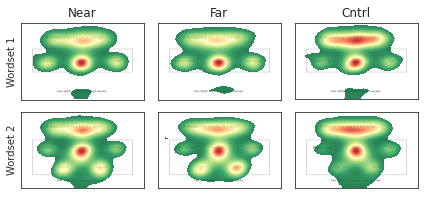

In [ ]:
# Heatmaps per wordset across stimuli

stims = ['Near', 'Far', 'Cntrl']

# Plot heatmaps
fig, axs = plt.subplots(2,3)

for i, ax in enumerate(axs.flatten()):
  wordset = 1 if i < 3 else 2
  stimuli = stims[i%3]

  img = plt.imread(f'Wordset images/{id_to_group(i+1)}_problem10_wordset{wordset}.png')

  data = gaze[ (gaze.wordset == wordset) & (gaze.stimuli == stimuli) & (gaze.confidence >= 0.8)]
  x, y = data[['x_scaled', 'y_scaled']].T.values
  
  heatmap = generate_heatmap(x,y)

  ax.imshow(heatmap.T,extent=extent, origin='lower', cmap='RdYlGn_r', alpha=0.85, zorder=1)
  ax.imshow(np.flipud(img), origin='lower', zorder=0)
  
  if stimuli == 'Near':
    ax.set_ylabel(f'Wordset {wordset}')

  if wordset == 1:
    ax.set_title(stimuli)

  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=-0.5)
plt.savefig('Heatmap_stimuli.pdf', dpi=600, bbox_inches='tight')
plt.show()

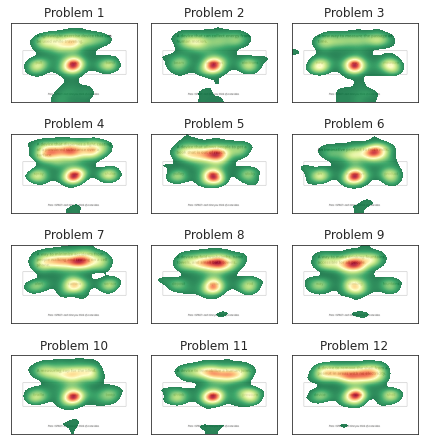

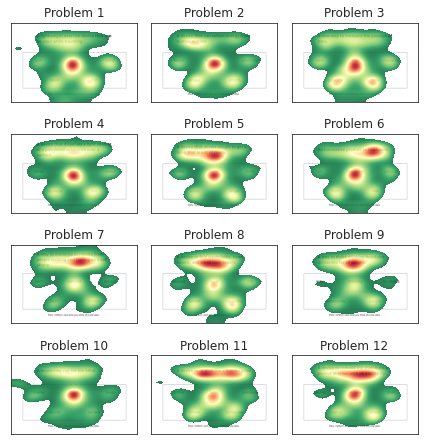

In [ ]:
# Heatmaps per problem
# Plot heatmaps

for wordset in range(1,3):
  fig, axs = plt.subplots(4,3, figsize=(6,8))

  w_data = gaze[(gaze.wordset == wordset) & (gaze.confidence >= 0.8)]
  for i, ax in enumerate(axs.flatten()):

    img = plt.imread(f'Wordset images/a_problem{i+1}_wordset{wordset}.png')

    data = w_data[w_data.problem_id == i+1]
    x, y = data[['x_scaled', 'y_scaled']].T.values
    
    heatmap = generate_heatmap(x,y)

    ax.imshow(heatmap.T,extent=extent, origin='lower', cmap='RdYlGn_r', alpha=0.85, zorder=1)
    ax.imshow(np.flipud(img), origin='lower', zorder=0)
    # ax.text(0.02, 0.02, f'{float(len(data)/cond_mask.sum())*100:.1f}%', ha='left', va='bottom', transform=ax.transAxes, fontsize=8) 
    # ax.text(0.98, 0.02, f'{stimuli}', ha='right', va='bottom', transform=ax.transAxes, fontsize=8) 
    
    ax.set_title(f'Problem {i+1}')

    ax.set_xticks([])
    ax.set_yticks([])

  plt.tight_layout()
  plt.subplots_adjust(hspace=-0.5)
  plt.savefig(f'Heatmap_problems_{wordset}.pdf', dpi=300, bbox_inches='tight')
  plt.show()

### Heatmap generation

In [ ]:
cond_mask = (gaze.participant_id == 23) & (gaze.wordset==1) & (gaze.problem_id == 4)

x, y = gaze[cond_mask & (gaze.confidence >= 0.8)][['x_scaled', 'y_scaled']].T.values
img = plt.imread(f'Wordset images/b_problem4_wordset1.png')

threshs = [False, False, True]
blurs = [None, 0.04, 0.04]
bin = [(50, int(50/(w/h))), (w,h), (w,h)]

fig, axs = plt.subplots(1,3, figsize=(12,3))

for i, ax in enumerate(axs):
  # Ensure square bins
  heatmap = generate_heatmap(x,y,bin[i],blurs[i],threshs[i])

  ax.imshow(heatmap.T,extent=extent, origin='lower', cmap='RdYlGn_r', alpha=0.85, zorder=1)
  ax.imshow(np.flipud(img), origin='lower', zorder=0)
  
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()

plt.savefig('Heatmap_viz.pdf', dpi=300)
plt.show()



## Gaze distribution

### AOI visualization

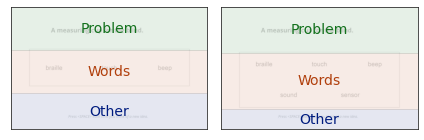

In [89]:
colors = sns.color_palette('dark',3)

fig, axs = plt.subplots(1,2)

for i, (wordset, border) in enumerate(borders.items()):
  for j, (k,v) in enumerate(border.items()):
    axs[i].axhspan(*v,zorder=1, alpha=0.1, facecolor=colors[j], linewidth=0.5, edgecolor='k')
    axs[i].text(w/2, np.mean(v), k, ha='center', va='center', fontsize=14, color=colors[j])
  axs[i].set_xticks([])
  axs[i].set_yticks([])

  img = plt.imread(f'Wordset images/a_problem10_wordset{wordset}.png')
  axs[i].imshow(np.flipud(img), origin='lower', zorder=0, alpha=0.2)

plt.tight_layout()
plt.savefig('Distribution_AOI.pdf', dpi=600, bbox_inches='tight')
plt.show()

### Statistics


In [ ]:
stims = ['Near', 'Far', 'Cntrl']

# Get distribution across AOIs
df_data = []
for wordset, border in borders.items():
  w_data = gaze[(gaze.wordset == wordset) & (gaze.confidence >= 0.8)]
  
  for p_id in range(1,25):
    p_data = w_data[w_data.participant_id == p_id]

    for prob_id in range(1,13):
      s_data = p_data[p_data.problem_id == prob_id]
      N = len(s_data)

      # Info about routine
      stim = s_data.stimuli.iloc[0]
      ideas = s_data.idea_total.iloc[0]
      line = [wordset, p_id,prob_id,stim, ideas]

      # Ratio for problem, words and other
      for loc, border_values in border.items():
        line.append(((s_data.on_surf) & (s_data.y_scaled.between(*border_values))).sum() / N)

      # Ratio for off-screen
      line.append((~s_data.on_surf).sum() / N)

      # Append values for wordset routine
      df_data.append(line)

# Generate dataframe
columns = ['Wordset', 'Participant', 'Problem ID','Stimuli','Ideas', 'Other', 'Words', 'Problem', 'Off-screen']
col_order = ['Wordset', 'Participant','Problem ID', 'Stimuli','Ideas', 'Problem', 'Words', 'Off-screen', 'Other']
gaze_dist = pd.DataFrame(df_data, columns=columns)[col_order]

gaze_dist

,Wordset,Participant,Problem ID,Stimuli,Ideas,Problem,Words,Off-screen,Other
0,1,1,1,Near,8,0.299680,0.457884,0.166902,0.075533
1,1,1,2,Far,4,0.295947,0.443570,0.170694,0.089790
2,1,1,3,Cntrl,4,0.320158,0.340111,0.286269,0.053461
3,1,1,4,Near,3,0.769901,0.115230,0.112782,0.002087
4,1,1,5,Far,8,0.346020,0.494110,0.124906,0.034965
...,...,...,...,...,...,...,...,...,...
571,2,24,8,Near,1,0.012649,0.824339,0.055759,0.107252
572,2,24,9,Far,3,0.650867,0.332404,0.001583,0.015147
573,2,24,10,Cntrl,0,0.320945,0.595603,0.056980,0.026471
574,2,24,11,Near,2,0.260583,0.616156,0.070980,0.052281


In [ ]:
gaze_dist_group = gaze_dist.groupby(by=['Wordset', 'Participant', 'Stimuli']).agg({**{col:'mean' for col in col_order[-4:]},**{'Ideas':'sum'}})
gaze_dist_group

Problem     Words  Off-screen     Other  Ideas
Wordset Participant Stimuli                                                 
1       1           Cntrl    0.332309  0.237284    0.401667  0.028740     18
                    Far      0.289765  0.525049    0.128353  0.056833     24
                    Near     0.411918  0.369930    0.167392  0.050760     20
        2           Cntrl    0.242058  0.711592    0.024789  0.021561     10
                    Far      0.477967  0.433584    0.051300  0.037148      8
...                               ...       ...         ...       ...    ...
2       23          Far      0.611361  0.340754    0.030310  0.017575      5
                    Near     0.468614  0.432486    0.049333  0.049568      8
        24          Cntrl    0.653858  0.293443    0.023361  0.029337      4
                    Far      0.367318  0.578190    0.019278  0.035214      9
                    Near     0.258769  0.616577    0.038389  0.086265     10

[144 rows x 5 columns]

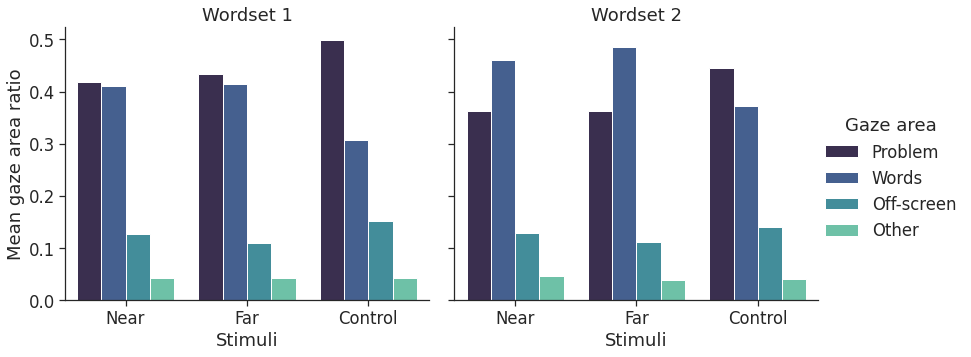

In [ ]:
gaze_dist_melt = gaze_dist_group.reset_index()
gaze_dist_melt = gaze_dist_melt.melt(id_vars = gaze_dist_melt.columns[:3], value_vars = gaze_dist_melt.columns[3:-1], var_name='Gaze area', value_name = 'Gaze area ratio')


stims = ['Near', 'Far', 'Cntrl']
stim_names = ['Near', 'Far', 'Control']

with sns.plotting_context("notebook", font_scale=1.5):
  f = sns.catplot(kind='bar', data=gaze_dist_melt, x='Stimuli', y='Gaze area ratio', hue='Gaze area', col='Wordset', order=stims, aspect=1.15, ci=None, palette='mako', sharey=True)
  f.set_xticklabels(stim_names)
  f.set_titles('Wordset {col_name}')
  f.set_ylabels('Mean gaze area ratio')
  f.savefig('gaze_distribution_area.pdf', dpi=300)

# Fixations

In [8]:
# Merge all fixations of same id --> into mean positions (due to movement in relation to monitor during fixation)
mean_cols = ['start_timestamp', 'duration', 'dispersion', 'norm_pos_x', 'norm_pos_y', 'x_scaled', 'y_scaled']
first_cols = ['on_surf', 'problem_id', 'stimuli', 'wordset', 'idea_total']

fixations_df = fixations.groupby(by=['participant_id', 'fixation_id']).agg({**{col: 'mean' for col in mean_cols}, **{col: 'first' for col in first_cols}}).reset_index()
fixations_df

,participant_id,fixation_id,start_timestamp,duration,dispersion,norm_pos_x,norm_pos_y,x_scaled,y_scaled,on_surf,problem_id,stimuli,wordset,idea_total
0,1,394,209.595699,112.0225,4.679987,0.231702,0.469230,444.866925,563.075683,True,1,Near,1,8
1,1,395,209.711713,241.9630,2.243299,0.208231,0.426117,399.803739,511.340365,True,1,Near,1,8
2,1,396,209.973708,464.8615,4.180975,0.230990,0.799823,443.501073,959.787440,True,1,Near,1,8
3,1,397,210.453681,137.9945,4.327803,0.230533,0.451332,442.623039,541.598139,True,1,Near,1,8
4,1,398,210.608499,491.4980,4.042879,0.485775,0.419207,932.687873,503.048861,True,1,Near,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84674,24,5701,2760.907320,432.6705,2.029565,0.514981,0.516938,988.763129,620.325474,True,10,Cntrl,2,0
84675,24,5702,2761.472037,101.3040,4.875184,0.618004,0.698022,1186.568438,837.626161,True,10,Cntrl,2,0
84676,24,5703,2761.576940,416.2180,3.892961,0.564463,0.694147,1083.769223,832.976842,True,10,Cntrl,2,0
84677,24,5704,2762.009609,467.5735,4.648099,0.776023,0.426503,1489.964155,511.803039,True,10,Cntrl,2,0


## Heatmap
Alternative of plotting heatmap based on gaze. Yielded the same result, visually speaking.

In [ ]:
def fixation_heatmap(x, y, values, bins=(w,h), blur=0.04,thres=True):
  '''
  blur - this will determine the gaussian blur kernel of the image (higher number = more blur)

  Based on: https://github.com/pupil-labs/pupil-tutorials/blob/master/02_load_exported_surfaces_and_visualize_aggregate_heatmap.ipynb
  '''
  # 2D histogram
  heatmap, xedges, yedges = np.histogram2d(x, y, weights=values, bins=bins, range=[[0,w],[0,h]])
  
  # Gaussian blur  
  if blur:
    filter_w = int(blur * w) // 2 * 2 + 1
    filter_h = int(blur * h) // 2 * 2 + 1
  
    heatmap = gaussian_filter(heatmap, sigma=(filter_w, filter_h))

  # Thresholding
  if thres:
    lowbound = np.mean(heatmap[heatmap > 0]) / 2
    heatmap[heatmap < lowbound] = np.nan

  return heatmap

In [ ]:
# Heatmaps per wordset across stimuli

stims = ['Near', 'Far', 'Cntrl']

# Plot heatmaps
fig, axs = plt.subplots(2,3)

for i, ax in enumerate(axs.flatten()):
  wordset = 1 if i < 3 else 2
  stimuli = stims[i%3]

  img = plt.imread(f'Wordset images/{id_to_group(i+1)}_problem10_wordset{wordset}.png')

  data = fixations_df[(fixations_df.wordset == wordset) & (fixations_df.stimuli == stimuli)]
  x, y, values = data[['x_scaled', 'y_scaled', 'duration']].T.values
  
  heatmap = fixation_heatmap(x,y, values)

  ax.imshow(heatmap.T,extent=extent, origin='lower', cmap='RdYlGn_r', alpha=0.85, zorder=1)
  ax.imshow(np.flipud(img), origin='lower', zorder=0)
  
  if stimuli == 'Near':
    ax.set_ylabel(f'Wordset {wordset}')

  if wordset == 1:
    ax.set_title(stimuli)

  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=-0.5)
plt.savefig('Fixation_heatmap_stimuli.pdf', dpi=600, bbox_inches='tight')
plt.show()

## Scanpaths

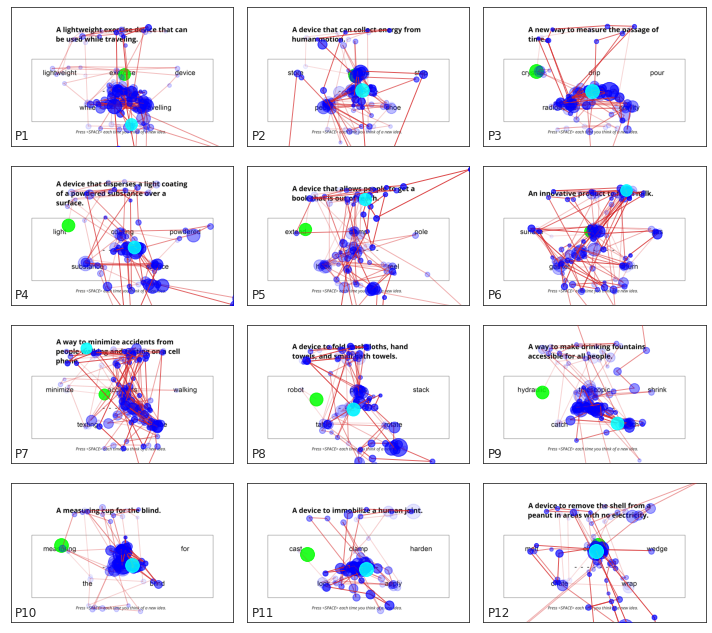

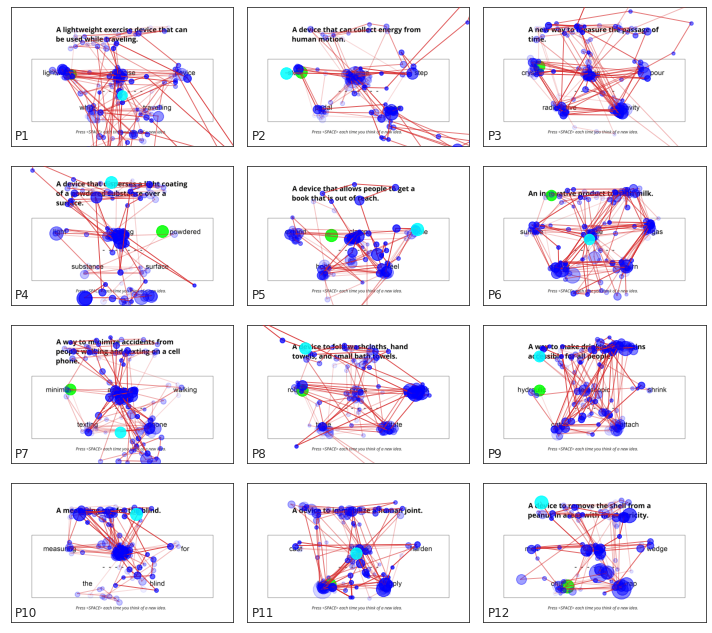

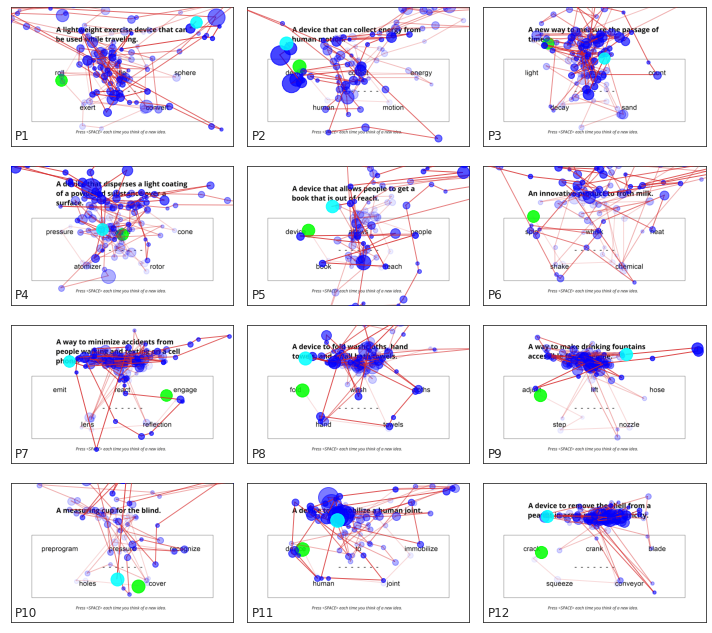

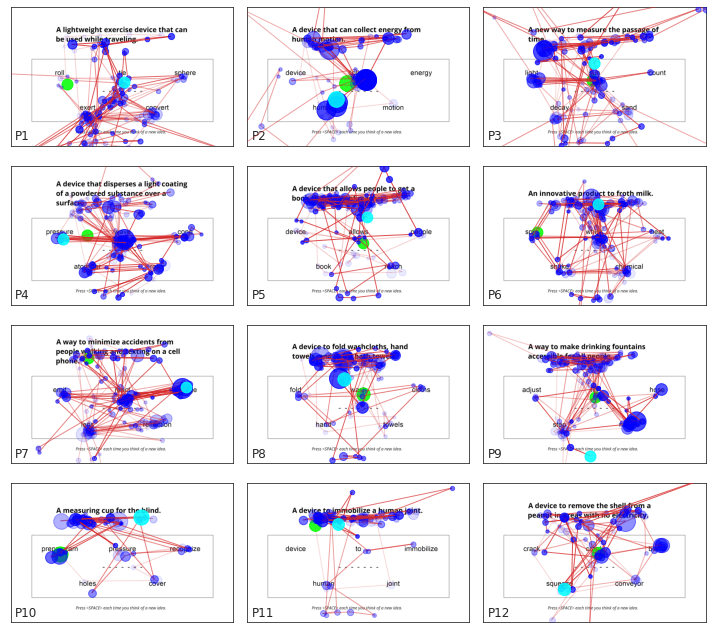

In [ ]:
wordset = 2

for participant_id in [3,6,8,11]:
  fig, axs = plt.subplots(4,3, figsize=(10,9))
  for p, ax in enumerate(axs.flatten()):
    problem_id = p + 1 

    img = plt.imread(f'Wordset images/{id_to_group(participant_id)}_problem{problem_id}_wordset{wordset}.png')
    ax.imshow(np.flipud(img), origin='lower', zorder=0)

    data = fixations_df[(fixations_df.problem_id == problem_id) & (fixations_df.wordset == wordset) & (fixations_df.participant_id == participant_id)]
    x, y, duration = data[['x_scaled', 'y_scaled', 'duration']].T.values

    N = len(duration)

    # Arbitrary value to mark end points of scanpaths
    size_ends = np.mean(duration) / 3

    for i in range(N):
      alpha = 0.15 + 0.70*(i/N)
      polyline = ax.plot(x[i:i+2], y[i:i+2], "C3", lw=1, alpha=alpha, solid_capstyle='round', zorder=i+1)
      
      # Add beginning and end in green and cyan, respectively. zorder ensures correct layer with scatter on top.
      if i == 0:
        points = ax.scatter(x[i], y[i], s=size_ends, alpha=0.85, color='lime',zorder=i+2)
      elif i == N-1:
        points = ax.scatter(x[i], y[i], s=size_ends, alpha=0.85, color='cyan',zorder=i+2)
      else:
        points = ax.scatter(x[i], y[i], s=duration[i]/10, alpha=alpha-0.1, color='blue',zorder=i+2)

    ax.text(0.02, 0.02, f'P{problem_id}', ha='left', va='bottom', fontsize=12,transform=ax.transAxes) 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(0,h)
    ax.set_xlim(0,w)

  plt.tight_layout()
  # plt.subplots_adjust(hspace=-0.5)
  plt.savefig(f'scanpath_p{participant_id}_w{wordset}_new.pdf', dpi=300, bbox_inches='tight')
# plt.show()

## Fixations distribution

In [85]:
stims = ['Near', 'Far', 'Cntrl']

# Get distribution across AOIs

df_data = []
for wordset, border in borders.items():
  w_data = fixations_df[fixations_df.wordset == wordset]
  
  for p_id in range(1,25):
    p_data = w_data[w_data.participant_id == p_id]

    for prob_id in range(1,13):
      s_data = p_data[p_data.problem_id == prob_id]
      
      # Total duration of all fixations in wordset routine (max. 60 s)
      N = s_data.duration.sum() 

      assert N <= 60000 # Cannot be longer than 60 000 ms routine

      # Info about routine
      stim = s_data.stimuli.iloc[0]
      ideas = s_data.idea_total.iloc[0]
      line = [wordset, p_id,prob_id,stim, ideas]

      # Ratio for problem, words and other
      for loc, border_values in border.items():
        ratio = s_data[(s_data.on_surf) & (s_data.y_scaled.between(*border_values))]['duration'].sum() / N
        line.append(ratio)

      # Ratio for off-screen
      ratio = s_data[~s_data.on_surf]['duration'].sum() / N
      line.append(ratio)

      # Append values for wordset routine
      df_data.append(line)

# Generate dataframe
columns = ['Wordset', 'Participant', 'Problem ID','Stimuli','Ideas', 'Other', 'Words', 'Problem', 'Off-screen']
col_order = ['Wordset', 'Participant','Problem ID', 'Stimuli','Ideas', 'Problem', 'Words', 'Off-screen', 'Other']
fix_dist = pd.DataFrame(df_data, columns=columns)[col_order]

fix_dist

,Wordset,Participant,Problem ID,Stimuli,Ideas,Problem,Words,Off-screen,Other
0,1,1,1,Near,8,0.320143,0.471518,0.145069,0.057992
1,1,1,2,Far,4,0.317682,0.470633,0.141582,0.070103
2,1,1,3,Cntrl,4,0.330216,0.341772,0.294928,0.030178
3,1,1,4,Near,3,0.798140,0.102941,0.090476,0.000000
4,1,1,5,Far,8,0.344244,0.500617,0.109424,0.029894
...,...,...,...,...,...,...,...,...,...
571,2,24,8,Near,1,0.012818,0.870210,0.062795,0.054177
572,2,24,9,Far,3,0.669428,0.330572,0.000000,0.000000
573,2,24,10,Cntrl,0,0.337446,0.586727,0.049788,0.026039
574,2,24,11,Near,2,0.280738,0.599300,0.077405,0.042557


In [86]:
fix_dist_group = fix_dist.groupby(by=['Wordset', 'Participant', 'Stimuli']).agg({**{col:'mean' for col in col_order[-4:]},**{'Ideas':'sum'}})
fix_dist_group

Problem     Words  Off-screen     Other  Ideas
Wordset Participant Stimuli                                                 
1       1           Cntrl    0.346688  0.220272    0.417913  0.012704     18
                    Far      0.300746  0.547525    0.108541  0.039234     24
                    Near     0.426882  0.388573    0.145330  0.034527     20
        2           Cntrl    0.245356  0.729256    0.013572  0.011817     10
                    Far      0.504515  0.433722    0.032388  0.028500      8
...                               ...       ...         ...       ...    ...
2       23          Far      0.629755  0.334859    0.016087  0.019298      5
                    Near     0.481067  0.429801    0.037970  0.051162      8
        24          Cntrl    0.678733  0.277909    0.016248  0.027110      4
                    Far      0.373304  0.592182    0.018076  0.016437      9
                    Near     0.268756  0.633361    0.040889  0.056993     10

[144 rows x 5 columns]

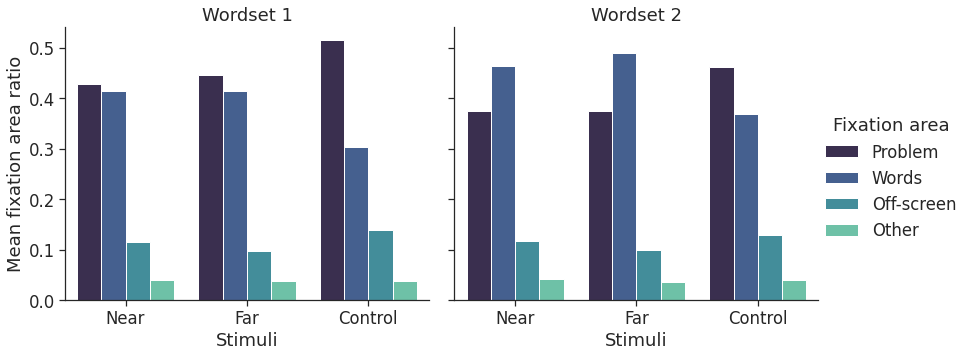

In [87]:
fix_dist_melt = fix_dist_group.reset_index()
fix_dist_melt = fix_dist_melt.melt(id_vars = fix_dist_melt.columns[:3], value_vars = fix_dist_melt.columns[3:-1], var_name='Fixation area', value_name = 'Fixation area ratio')

stims = ['Near', 'Far', 'Cntrl']
stim_names = ['Near', 'Far', 'Control']

with sns.plotting_context("notebook", font_scale=1.5):
  f = sns.catplot(kind='bar', data=fix_dist_melt, x='Stimuli', y='Fixation area ratio', hue='Fixation area', col='Wordset', order=stims, aspect=1.15, ci=None, palette='mako', sharey=True)
  f.set_xticklabels(stim_names)
  f.set_titles('Wordset {col_name}')
  f.set_ylabels('Mean fixation area ratio')

# f.savefig('fixation_distrubution_area.pdf', dpi=300)

### Significance statistics

In [88]:
 AOIs = ['Problem','Words', 'Off-screen', 'Other']

for aoi in AOIs:
  print(aoi)
  # anova = pg.rm_anova(data=fix_dist[fix_dist.Wordset == 2], dv=aoi, subject='Participant', within='Stimuli')
  # pg.print_table(anova)
  
  print(pg.normality(data=fix_dist[fix_dist.Wordset == 2], dv=aoi, group='Stimuli'))
  # sns.displot(kind=kde,)
  # pg.print_table(pg.pairwise_ttests(data=fix_dist[fix_dist.Wordset == 2], dv=aoi, within='Stimuli', subject='Participant', padjust='bonf'))


Problem
              W      pval  normal
Near   0.957781  0.003588   False
Far    0.950145  0.001120   False
Cntrl  0.969009  0.022522   False
Words
              W      pval  normal
Near   0.978342  0.112921    True
Far    0.981049  0.179947    True
Cntrl  0.944507  0.000494   False
Off-screen
              W          pval  normal
Near   0.823192  2.334187e-09   False
Far    0.764262  4.143660e-11   False
Cntrl  0.764011  4.079264e-11   False
Other
              W          pval  normal
Near   0.760911  3.365461e-11   False
Far    0.805666  6.484538e-10   False
Cntrl  0.725120  4.091681e-12   False


## Duration and other measures

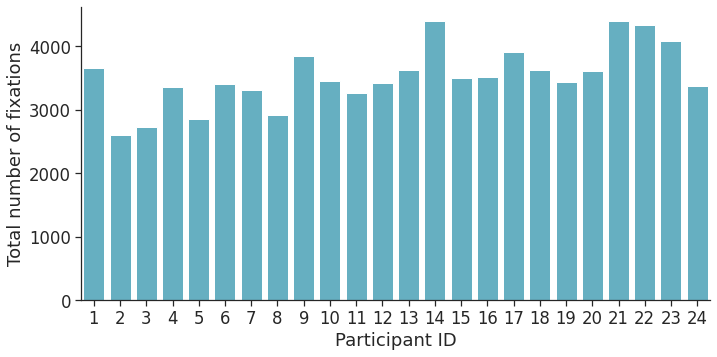

In [ ]:
# Total number of fixations
with sns.plotting_context("notebook", font_scale=1.5):
  f = sns.catplot(kind='count',data=fixations_df, x='participant_id', aspect=2, color=colors[5])
  f.set_xlabels('Participant ID')
  f.set_ylabels('Total number of fixations')


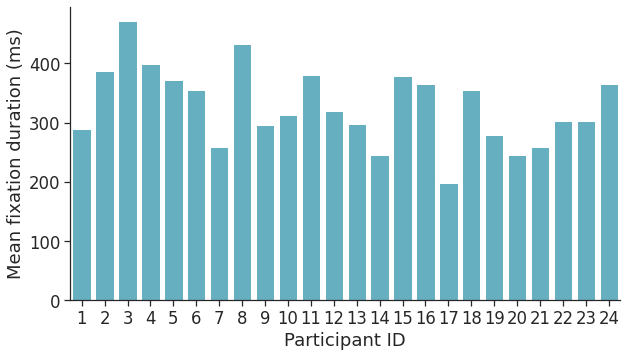

In [ ]:
# Avg. fixation duration
with sns.plotting_context("notebook", font_scale=1.5):
  f = sns.catplot(kind='bar',data=fixations_df, x='participant_id', y='duration', aspect=1.75, color=colors[5], ci=None)
  f.set_xlabels('Participant ID')
  f.set_ylabels('Mean fixation duration (ms)')

f.savefig('avg_fix_duration.pdf',dpi=300, bbox_inches='tight')

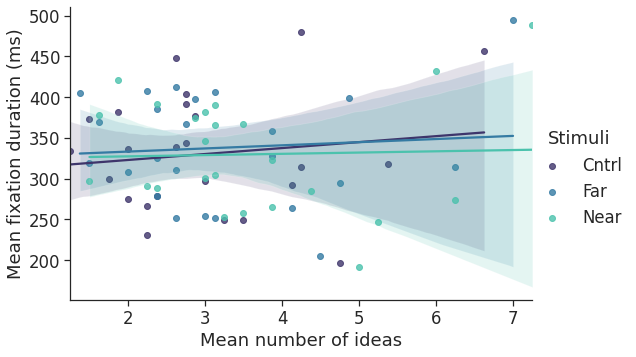

In [66]:
# scatter_df = fixations_df.groupby(by=['participant_id', 'problem_id', 'wordset']).agg({'idea_total':'first', 'duration':'mean'}) \
#         .groupby('participant_id').agg({'idea_total':'sum', 'duration':'mean'})

scatter_df = fixations_df.groupby(by=['participant_id', 'problem_id', 'wordset']).agg({'stimuli':'first','idea_total':'first', 'duration':'mean'}) \
    .groupby(by=['participant_id', 'stimuli']).agg({'idea_total':'mean', 'duration':'mean'})

scatter_df
with sns.plotting_context("notebook", font_scale=1.5):
  f = sns.lmplot(data=scatter_df.reset_index(), x='idea_total', y='duration', aspect=1.5, hue='stimuli', palette='mako')
  f.set_xlabels('Mean number of ideas')
  f.set_ylabels('Mean fixation duration (ms)')
  f._legend.set_title('Stimuli')

f.savefig('ideas_duration_reg.pdf', dpi=300)

# Pupillometry

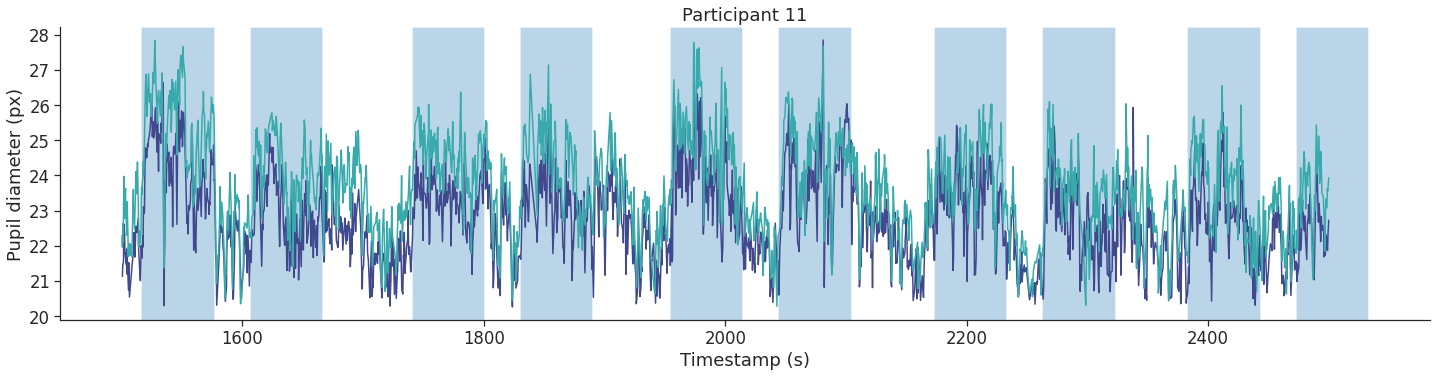

In [ ]:
# Extract plots, bar represent wordsets (idwation) 
for p in [11]:

  d = 'diameter'

  subset = all_pupil[(all_pupil.participant_id == p) & (all_pupil.confidence >= 0.95)][['pupil_timestamp', 'eye_id', d]]

  label = '(px)'
  # Remove NaN for 2d samples
  if d == 'diameter_3d':
    subset = subset.dropna()
    label = '(mm)'


  # Remove outliers outside below 1% percentile and above 99% quantile
  q_low = subset[d].quantile(0.01)
  q_hi  = subset[d].quantile(0.99)

  subset = subset[subset[d].between(q_low, q_hi)]

  # Downsample data, only every 30th data point
  resample = subset.sort_values('eye_id')[::120]

  # Choose only part of the timeline
  start, stop = 1500, 2500
  plot_data = resample[resample.pupil_timestamp.between(start,stop)]

  with sns.plotting_context("notebook", font_scale=1.5):
    f = sns.relplot(data=plot_data, x='pupil_timestamp', y=d, hue='eye_id', aspect=4, kind='line', palette='mako', legend=False)
    for row in annots[(annots.participant_id == p) & (annots.label == 'wordset') & (annots.timestamp.between(start,stop))][['timestamp', 'duration']].itertuples(index=False):
      f.ax.axvspan(row[0], sum(row), alpha=0.3)

    f.ax.set_title(f'Participant {p}')
    f.set(ylabel='Pupil diameter ' + label, xlabel='Timestamp (s)')

  # plt.show()
  f.savefig(f'{d}_participant{p}.pdf',dpi=300) 


# Blinks

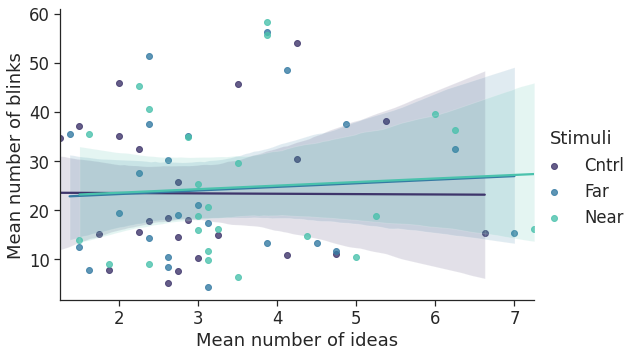

In [83]:
blink_df =  blinks[blinks.duration < 2.0].groupby(by=['participant_id', 'problem_id', 'wordset'])\
    .agg({'stimuli':'first','idea_total':'first', 'id':'count'}).groupby(by=['participant_id', 'stimuli'])\
    .agg({'idea_total':'mean', 'id':'mean'})

blink_df

with sns.plotting_context("notebook", font_scale=1.5):
  f = sns.lmplot(data=blink_df.reset_index(), x='idea_total', y='id', aspect=1.5, hue='stimuli', palette='mako')
  f.set_xlabels('Mean number of ideas')
  f.set_ylabels('Mean number of blinks')
  f._legend.set_title('Stimuli')

  f.savefig('ideas_blinks_reg.pdf', dpi=300)